This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


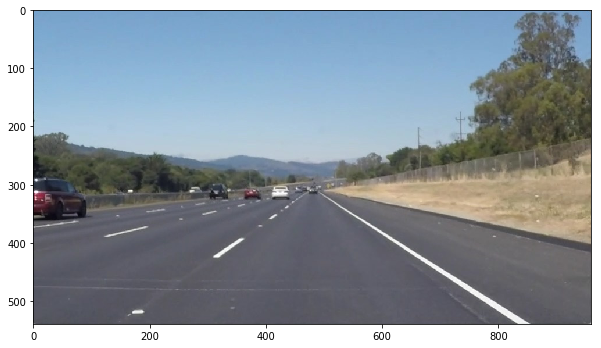

In [10]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from math import pi
from mpl_toolkits.axes_grid1 import ImageGrid
import scipy.stats.mstats as mstats


#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image


In [11]:

import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, left, right, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    """
    What do we know about lane lines?
     - They are relatively perpendicular
     - They should exist at the same length on either side.
    """
    global prev

    if len(left) == 0 or len(right) == 0:
        return img

    left_x, left_y, left_m, left_c = lines_linreg(left)
    right_x, right_y, right_m, right_c = lines_linreg(right)

    min_y = np.min([np.min(left_y), np.min(right_y)])

    top_right_point = np.array([(min_y - right_c) / right_m, min_y], dtype=int)
    top_left_point = np.array([(min_y - left_c) / left_m, min_y], dtype=int)


    max_y = np.max([np.max(right_y), np.max(left_y)])
    bottom_left_point = np.array([(max_y - left_c) / left_m, max_y], dtype=int)
    bottom_right_point = np.array([(max_y - right_c) / right_m, max_y], dtype=int)

    cv2.line(img, (bottom_left_point[0], bottom_left_point[1]), (top_left_point[0], top_left_point[1]), [255, 0, 0], thickness)
    cv2.line(img, (bottom_right_point[0], bottom_right_point[1]), (top_right_point[0], top_right_point[1]), [255, 0, 0], thickness)
    return img


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    #line_img = np.zeros(img.shape, dtype=np.uint8)
    #draw_lines(line_img, lines)
    #return line_img
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def load_image(filename):
    return mpimg.imread('test_images/%s' % filename)

def slope_filter(lines_array, positive, min_slope, max_slope):
    slopes = np.apply_along_axis(lambda row: (row[3] - row[1]) / (row[2] - row[0]), 2, lines_array)

    if positive:
        slopes[slopes > max_slope] = 0
        slopes[slopes < min_slope] = 0
        lines_array = np.array(lines_array[np.where(slopes > 0)])
    else:
        slopes[slopes < -max_slope] = 0
        slopes[slopes > -min_slope] = 0
        lines_array = np.array(lines_array[np.where(slopes < 0)])

    return lines_array


def lines_linreg(lines_array):
    x = np.reshape(lines_array[:, [0, 2]], (1, len(lines_array) * 2))[0]
    y = np.reshape(lines_array[:, [1, 3]], (1, len(lines_array) * 2))[0]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y)[0]
    x = np.array(x)
    y = np.array(x * m + c)
    return x, y, m, c


def pipeline(image, verbose=False):
    img_shape = image.shape

    if verbose:
        print('Processing image.')

    width = img_shape[1]
    height = img_shape[0]
    ratio = 5/8

    roi_left = np.array([[
        (100, height),
        ((1 - ratio) * width, ratio * height),
        (.5 * width, ratio * height),
        (.5 * width, height)
    ]], dtype=np.int32)

    roi_right = np.array([[
        (.5 * width, height),
        (.5 * width, ratio * height),
        (ratio * width, ratio * height),
        (width, height)
    ]], dtype=np.int32)

    canny_low_threshold = 80
    canny_high_threshold = 200
    rho = 2  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 20  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20  # minimum number of pixels making up a line
    max_line_gap = 10  # maximum gap in pixels between connectable line segments
    gaussian_kernel = 5

    img = image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.subplot(231)
    plt.imshow(img, cmap='gray')

    img = gaussian_noise(img, gaussian_kernel)
    plt.subplot(232)
    plt.imshow(img, cmap='gray')

    img = canny(img, canny_low_threshold, canny_high_threshold)
    plt.subplot(233)
    plt.imshow(img, cmap='gray')

    img = cv2.dilate(img, cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 5)))

    edges_left = region_of_interest(img, [roi_left])
    edges_right = region_of_interest(img, [roi_right])

    plt.subplot(234)
    plt.imshow(edges_left, cmap='gray')

    plt.subplot(235)
    plt.imshow(edges_right, cmap='gray')

    hough_left = hough_lines(edges_left, rho, theta, threshold, min_line_length, max_line_gap)
    hough_right = hough_lines(edges_right, rho, theta, threshold, min_line_length, max_line_gap)

    if hough_left is None or hough_right is None:
        return image

    lines_left = slope_filter(hough_left, False, .5, .9)
    lines_right = slope_filter(hough_right, True, .5, .9)

    color_with_lines = np.zeros(image.shape, dtype=np.uint8)
    color_with_lines = draw_lines(color_with_lines, lines_left, lines_right, [255, 0, 0], 10)
    out = weighted_img(color_with_lines, image)

    plt.subplot(236)
    plt.imshow(out)

    if verbose:
        plt.show()
    return out

In [13]:
import os
os.listdir("test_images/")

['.DS_Store',
 '.ipynb_checkpoints',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # put pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    return pipeline(image)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:16<00:00, 13.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 13.7 s, sys: 1.6 s, total: 15.3 s
Wall time: 17.4 s


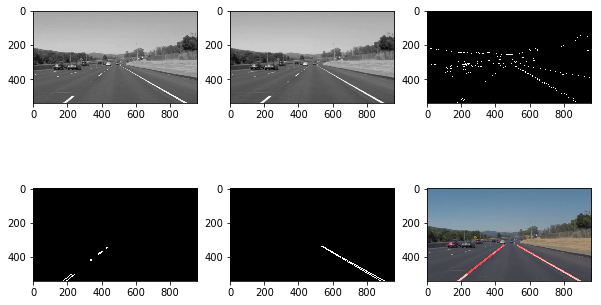

In [16]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

In [17]:

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))